# Combined File

This file should combine all the other experiments

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.colors import to_rgb
from matplotlib.colors import LinearSegmentedColormap

# Model and Training Params

In [5]:
# Model Params
num_hidden = 8 # number of hidden layers. The total network has additionl 2 layers: input to hidden and hidden to output
input_dim = 2
hidden_dim = 2
output_dim = 1
activation = 'tanh' #'relu' and 'tanh' are supported

# Training Params
cross_entropy = False #True supported with binary classification only
num_epochs = 800

180
180
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [

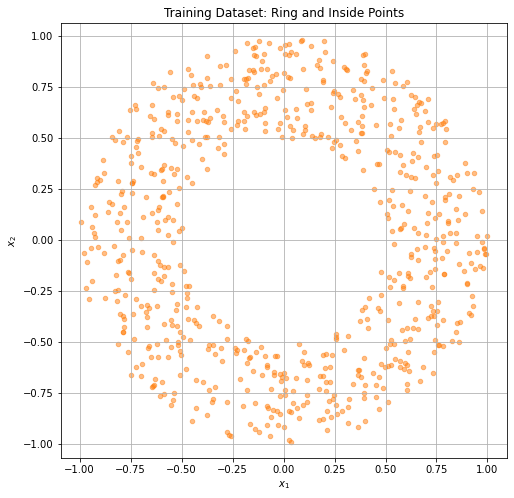

In [23]:
import models.training
from models.training import make_circles_uniform

# Generate training data

# Set random seed for reproducibility
seed = np.random.randint(1000)
# seed = 163
print(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#footnnote to display on plots to make sure that plots and model/trainign params do not get confused
footnote = f'num_hidden={num_hidden}, input_dim={input_dim}, hidden_dim={hidden_dim}, output_dim={output_dim}, activation={activation}, seed={seed}'

n_points = 2000 #number of points in the dataset

inner_radius = 0.5
outer_radius = 1
buffer = 0.2

import importlib
importlib.reload(models.training) # Reload the module

train_loader, test_loader = make_circles_uniform(output_dim = 1, n_samples = n_points, inner_radius = 0.5, outer_radius = 1.0, buffer = 0.3, cross_entropy=cross_entropy, seed = seed)

In [10]:
for input, label in train_loader:
    print(input[:5], label[:5])
    break

tensor([[-0.3376,  0.7144],
        [ 0.0749, -0.1311],
        [ 0.6686, -0.4027],
        [ 0.1318, -0.1472],
        [ 0.9484,  0.0703]]) tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.]])


# Define model and training


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, features, shortcut_param = 1, activation = 'relu', batchnorm = True):

        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(features, features)
        if batchnorm: #batchnorm is important to stabilize the training for deeper networks
            self.bn = nn.BatchNorm1d(features)
            
        if activation == 'relu':
            self.activation = nn.ReLU()
        if activation == 'tanh':
            self.activation = nn.Tanh()
        if activation == 'id':
            self.activation = nn.Identity()
        self.shortcut_param = shortcut_param
    def forward(self, x):
        identity = x #cont here
        out = self.fc(x)
        if hasattr(self, 'bn'):
            out = self.bn(out)
        out = self.activation(out)
        out = out + self.shortcut_param * identity
        return out

class ResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden, shortcut_param = 1, activation = 'relu'):
        super(ResNet, self).__init__()
        self.num_hidden = num_hidden
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        if activation == 'relu':
            self.activation = nn.ReLU()
        if activation == 'tanh':
            self.activation = nn.Tanh()
        if activation == 'id':
            self.activation = nn.Identity()
            
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim, shortcut_param=shortcut_param, activation = activation) for _ in range(num_hidden)]
        )
        self.output_fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, output_layer = True):
        x = self.activation(self.input_fc(x))
        x = self.res_blocks(x)
        if output_layer:
            x = self.output_fc(x)
            x = torch.sigmoid(x)
        return x
    
    '''
    sub_model is used to access a partial network of the input to output network
    layers are counted from 0 (input to hidden dim) until nth layer ( (n-1)th hidden layer to output layer)
    from_layer is the starting layer that is included in the sub_model
    to_layer is the final layer included in the sub_model
    e.g. from_layer = 1, to_layer = 2 includes the first two ResBlocks
    initial layer is counted as layer 0
    hidden to output layer is counted as final layer
    '''
    def sub_model(self, x, from_layer, to_layer):
        if to_layer > self.num_hidden + 1:
            print('Error: to_layer is larger than existing number of layers')
            return
        if from_layer > to_layer:
            print('Error: to_layer cannot be larger than from_layer')
        
        
        if from_layer == 0:
            x = self.activation(self.input_fc(x))
            from_layer += 1 #if from_layer = 0 I need to increase the from_layer count

        if to_layer > 0 and from_layer < self.num_hidden + 1:
            reduced_block = self.res_blocks[from_layer - 1 : to_layer] #from layer 1 to 2 means hidden layer 0 to hidden layer 1
            x = reduced_block(x)
        if to_layer == self.num_hidden + 1:
            x = self.output_fc(x)
        return x
            


MSELoss()
Epoch [1/800], Loss: 0.2623
Epoch [20/800], Loss: 0.0776
Epoch [40/800], Loss: 0.0610
Epoch [60/800], Loss: 0.0466
Epoch [80/800], Loss: 0.0485
Epoch [100/800], Loss: 0.0459
Epoch [120/800], Loss: 0.0510
Epoch [140/800], Loss: 0.0517
Epoch [160/800], Loss: 0.0483
Epoch [180/800], Loss: 0.0474
Epoch [200/800], Loss: 0.0438
Epoch [220/800], Loss: 0.0426
Epoch [240/800], Loss: 0.0468
Epoch [260/800], Loss: 0.0441
Epoch [280/800], Loss: 0.0405
Epoch [300/800], Loss: 0.0444
Epoch [320/800], Loss: 0.0451
Epoch [340/800], Loss: 0.0409
Epoch [360/800], Loss: 0.0463
Epoch [380/800], Loss: 0.0486
Epoch [400/800], Loss: 0.0427
Epoch [420/800], Loss: 0.0439
Epoch [440/800], Loss: 0.0392
Epoch [460/800], Loss: 0.0271
Epoch [480/800], Loss: 0.0155
Epoch [500/800], Loss: 0.0231
Epoch [520/800], Loss: 0.0189
Epoch [540/800], Loss: 0.0109
Epoch [560/800], Loss: 0.0063
Epoch [580/800], Loss: 0.0108
Epoch [600/800], Loss: 0.0122
Epoch [620/800], Loss: 0.0114
Epoch [640/800], Loss: 0.0185
Epoch 

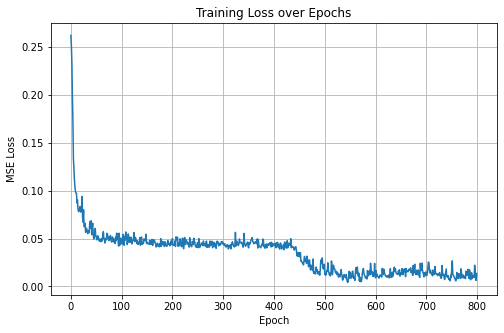

In [ ]:

model = ResNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_hidden=num_hidden, shortcut_param=0, activation=activation)

if 'load_file' not in locals():  # Only enter retry loop if no model is being loaded
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    if cross_entropy: 
        criterion = nn.BCEWithLogitsLoss()
    else: criterion = nn.MSELoss()

    print(criterion)
    # Training loop

    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs.size())
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if (epoch+1) % 20 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')
        losses.append(epoch_loss / len(train_loader))
        
# --- Save Checkpoint ---
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(), # Good practice to save optimizer state too
        'losses': losses,
        'seed': seed,
        'epoch': epoch, # Save the last epoch number
        'input_dim': input_dim, # Save hyperparameters for verification/reproducibility
        'hidden_dim': hidden_dim,
        'output_dim': output_dim,
        'num_blocks': num_hidden,
        'cross_entropy': cross_entropy
    }
    save_path = f'last.pth'
    torch.save(checkpoint, save_path)
    print(f'Checkpoint saved to {save_path}')
    # We have the losses from training directly
        


else:
    load_path = load_file + '.pth'
    try:
        print(f"--- Loading Checkpoint from: {load_path} ---")
        checkpoint = torch.load(load_path)

        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])

        # Load losses and seed from the checkpoint
        losses = checkpoint.get('losses', []) # Use .get for backward compatibility if 'losses' key is missing
        loaded_seed = checkpoint.get('seed', 'Not Found') # Use .get for backward compatibility

        # Optionally load optimizer state if you plan to resume training
        # optimizer = torch.optim.Adam(model.parameters()) # Re-initialize optimizer
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # start_epoch = checkpoint['epoch'] + 1 # To resume training

        # Load other saved info (optional, but good for verification)
        loaded_input_dim = checkpoint.get('input_dim', 'Not Found')
        loaded_hidden_dim = checkpoint.get('hidden_dim', 'Not Found')
        loaded_output_dim = checkpoint.get('output_dim', 'Not Found')
        loaded_num_blocks = checkpoint.get('num_blocks', 'Not Found')
        loaded_cross_entropy = checkpoint.get('cross_entropy', 'Not Found')
        last_epoch = checkpoint.get('epoch', 'Not Found')


        print(f"Model state loaded successfully.")
        print(f"Loaded training losses (Length: {len(losses)}).")
        print(f"Original training seed: {loaded_seed}")
        print(f"Model trained for {last_epoch + 1 if isinstance(last_epoch, int) else 'N/A'} epochs.")
        print(f"Saved Hyperparameters: Input={loaded_input_dim}, Hidden={loaded_hidden_dim}, Output={loaded_output_dim}, Blocks={loaded_num_blocks}, CrossEntropy={loaded_cross_entropy}")


        model.eval() # Set model to evaluation mode after loading
        print("Model set to evaluation mode.")

    except FileNotFoundError:
        print(f"Error: Checkpoint file not found at {load_path}")
        losses = [] # Ensure losses is an empty list if loading failed


# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()



In [28]:
model.parameters

<bound method Module.parameters of ResNet(
  (input_fc): Linear(in_features=2, out_features=2, bias=True)
  (activation): ReLU()
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (1): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (2): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (3): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (4)

In [29]:
import plots.plots 
from plots.plots import plot_decision_boundary


Plot saved to test.png


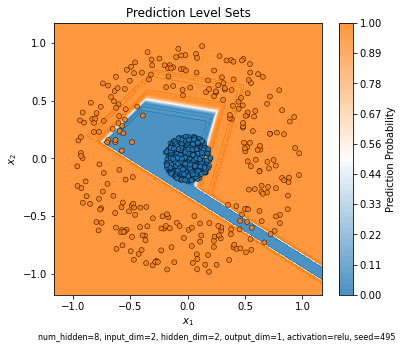

In [30]:
# import importlib
# importlib.reload(plots.plots) # Reload the module

X_test, y_test = next(iter(test_loader))
plot_decision_boundary(model, X_test, y_test, show=True, file_name= 'test', footnote = footnote)

Training model with shortcut_param = 0.00
495
Training model with shortcut_param = 0.12
495
Training model with shortcut_param = 0.25
495
Training model with shortcut_param = 0.38
495
Training model with shortcut_param = 0.50
495
Training model with shortcut_param = 0.62
495
Training model with shortcut_param = 0.75
495
Training model with shortcut_param = 0.88
495
Training model with shortcut_param = 1.00
495


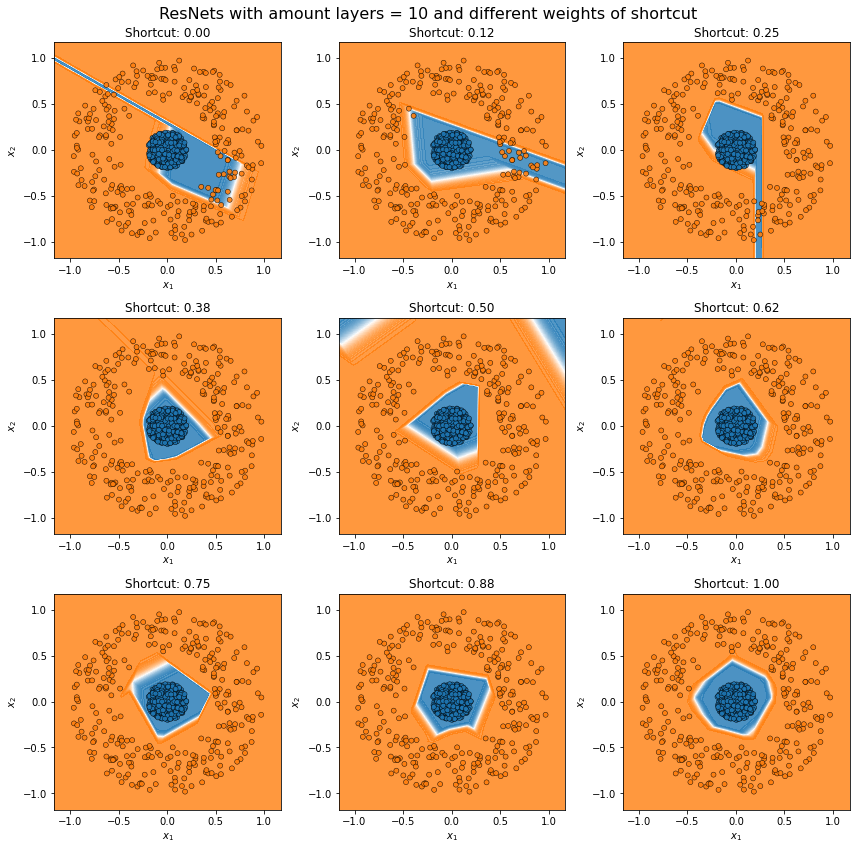

In [ ]:
X_test, y_test = next(iter(test_loader))
# num_epochs = 300

shortcut_values = np.linspace(0, 1, 9)  # e.g., [0.0, 0.125, ..., 1.0]
# shortcut_values = [0, 0, 0 , 0 , 0]  # e.g., [0.0, 0.125, ..., 1.0]
n_cols = 3
n_rows = int(np.ceil(len(shortcut_values) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), facecolor='white')
# num_epochs = 10
for idx, shortcut in enumerate(shortcut_values):
    print(f"Training model with shortcut_param = {shortcut:.2f}")
    
    # seed = 163
    print(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    model = ResNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
                   num_hidden=num_hidden, shortcut_param=shortcut, activation=activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCEWithLogitsLoss() if cross_entropy else nn.MSELoss()

    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    ax = axes.flatten()[idx]
    plot_decision_boundary(model, X_test, y_test, title=f"Shortcut: {shortcut:.2f}", ax=ax, show=False, colorbar=False)

# Hide unused subplots
for i in range(len(shortcut_values), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

fig.suptitle(f"ResNets with amount layers = {num_hidden + 2} and different weights of shortcut", fontsize=16)

# 💡 Leave room at top for the title
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.tight_layout()
plt.show()

# Singular value computations and plotting
We want to determine singular points in the compact space

In [21]:
# Define a grid over the input space.
grid_size = 200 # Adjust as needed.

def psi_manual(x, func):
    """
    x: a tensor of shape (2,) representing a point in R^2.
    model: a function mapping R^2 to R^output_dim.
    
    Returns:
      The smallest singular value of the Jacobian of model at x.
    """
    # Ensure x is a leaf variable with gradient tracking enabled.
    x = x.clone().detach().requires_grad_(True)
    
    # Define a lambda function to ensure accurate input-output mapping
    # func = lambda inp: model(inp, output_layer = False)
    
    # Compute the Jacobian using torch.autograd.functional.jacobian (compatible with Python 3.8)
    jacobian = torch.autograd.functional.jacobian(func, x, create_graph=True)
    
    # Compute singular values using svdvals (available in PyTorch 1.8, compatible with Python 3.8)
    singular_values = torch.svd(jacobian, compute_uv=False)[1] #svd interprets here the jacobian as a SQUARE matrix of the largest dimension, hence it 
    
   
    return singular_values.detach().numpy()



x_range = np.linspace(-1, 1, grid_size)
y_range = np.linspace(-1, 1, grid_size)
psi_values = np.zeros((grid_size, grid_size, 2))

# Put the model in evaluation mode.
model.eval()
func = lambda inp: model(inp, output_layer = False)

# Evaluate psi(x) over the grid.
for i, xv in enumerate(x_range):
    for j, yv in enumerate(y_range):
        # Create a 2D point as a torch tensor.
        x_point = torch.tensor([xv, yv], dtype=torch.float32)
        psi_values[j, i,:] = psi_manual(x_point, func)

ValueError: expected 2D or 3D input (got 1D input)

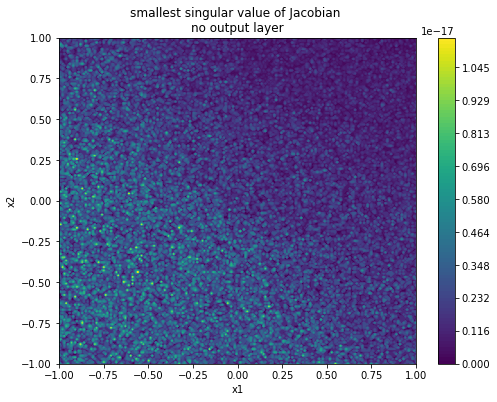

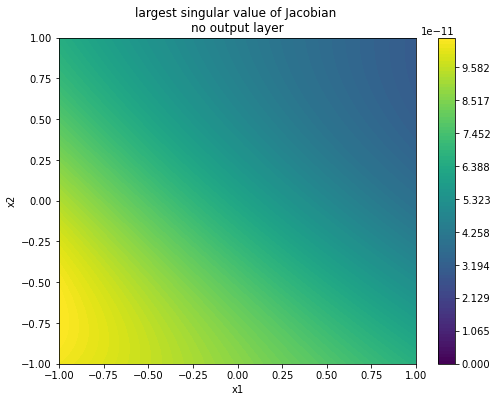

In [ ]:

# Plot the contour corresponding to psi ~ 0.
plt.figure(figsize=(8, 6))
# Here we plot the contour at a small level, e.g., 0.01.
# CS = plt.contour(x_range, y_range, psi_values, levels=[0,0.05,0.1,0.2,0.3], colors='red')

# Define the number of levels for the contour plot
vmin1, vmax1 = psi_values[:, :, 1].min(), psi_values[:, :, 1].max()
num_levels = 100
levels1 = np.linspace(0, vmax1, num_levels)
# Create the contour plot using the 'binary' colormap
CS = plt.contourf(x_range, y_range, psi_values[:,:,1], levels=levels1, cmap = 'viridis')
cbar = plt.colorbar(CS)
plt.title('smallest singular value of Jacobian \nno output layer')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Plot the contour corresponding to psi ~ 0.
plt.figure(figsize=(8, 6))
# Here we plot the contour at a small level, e.g., 0.01.
# CS = plt.contour(x_range, y_range, psi_values, levels=[0,0.05,0.1,0.2,0.3], colors='red')

# Define the number of levels for the contour plot

vmin0, vmax0 = psi_values[:, :, 0].min(), psi_values[:, :, 0].max()
num_levels = 100
levels0 = np.linspace(0, vmax0, num_levels)
# Create the contour plot using the 'binary' colormap
CS = plt.contourf(x_range, y_range, psi_values[:,:,0], levels=levels0, cmap = 'viridis')
cbar = plt.colorbar(CS)
plt.title('largest singular value of Jacobian \nno output layer')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()



KeyboardInterrupt: 

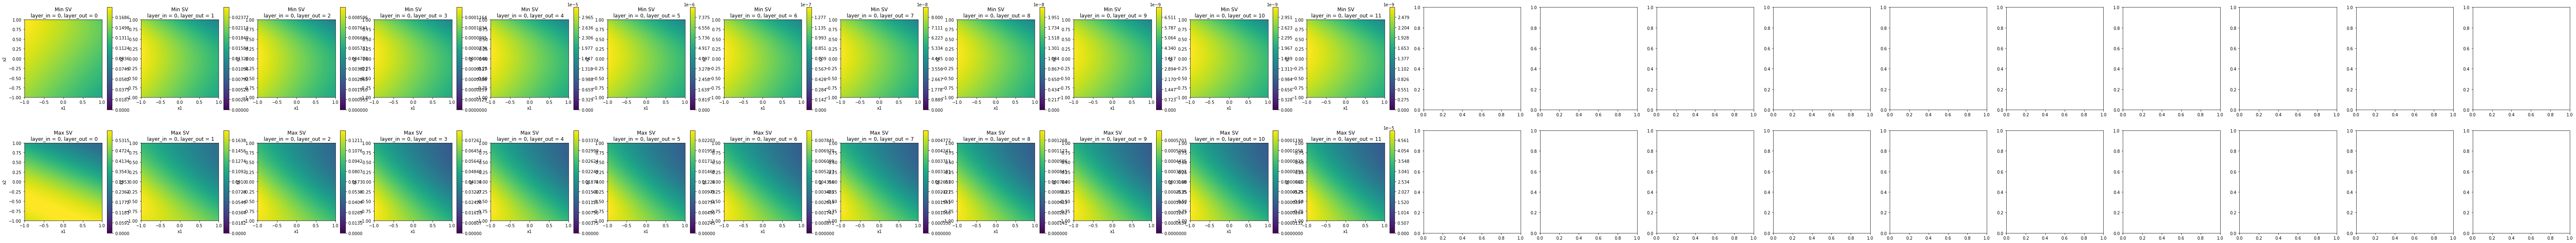

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Put the model in evaluation mode.
model.eval()

# Prepare figure and axes
fig, axes = plt.subplots(2, num_hidden + 2, figsize=(5 * (num_hidden + 2), 10))  # Adjust figsize if needed

for layer in range(num_hidden + 2):
    func = lambda inp: model.sub_model(inp, from_layer=0, to_layer = layer)

    # Evaluate psi(x) over the grid.
    for i, xv in enumerate(x_range):
        for j, yv in enumerate(y_range):
            x_point = torch.tensor([xv, yv], dtype=torch.float32)
            psi_values[j, i, :] = psi_manual(x_point, func)

    # Determine contour levels
    vmin1, vmax1 = psi_values[:, :, 1].min(), psi_values[:, :, 1].max()
    num_levels_contour = 200
    levels1 = np.linspace(0, vmax1, num_levels_contour)

    # Plot smallest singular value (index 1) - first row
    ax = axes[0, layer] if num_hidden > 1 else axes[0]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 1], levels=levels1, cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Min SV\n layer_in = 0, layer_out = {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')
    
    # Determine contour levels
    vmin0, vmax0 = psi_values[:, :, 0].min(), psi_values[:, :, 0].max()
    num_levels_contour = 200
    levels0 = np.linspace(0, vmax0, num_levels_contour)
    

    # Plot largest singular value (index 0) - second row
    ax = axes[1, layer] if num_hidden > 1 else axes[1]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 0], levels=levels0, cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Max SV\n layer_in = 0, layer_out = {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Put the model in evaluation mode.
model.eval()

# Prepare figure and axes
fig, axes = plt.subplots(2, num_hidden + 2, figsize=(5 * (num_hidden + 2), 10))  # Adjust figsize if needed

x_range = np.linspace(-1, 1, grid_size)
y_range = np.linspace(-1, 1, grid_size)

for layer in range(num_hidden + 2):
    func = lambda inp: model.sub_model(inp, from_layer = layer, to_layer=layer)

    # Evaluate psi(x) over the grid.
    for i, xv in enumerate(x_range):
        for j, yv in enumerate(y_range):
            x_point = torch.tensor([xv, yv], dtype=torch.float32)
            psi_values[j, i, :] = psi_manual(x_point, func)

    # Determine contour levels
    vmin1, vmax1 = psi_values[:, :, 1].min(), psi_values[:, :, 1].max()
    num_levels_contour = 200
    levels1 = np.linspace(0, vmax1, num_levels_contour)

    # Plot smallest singular value (index 1) - first row
    ax = axes[0, layer] if num_hidden > 1 else axes[0]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 1], 
                     levels=levels1,
                     cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Min SV\n layer {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')
    

    # Determine contour levels
    vmin0, vmax0 = psi_values[:, :, 0].min(), psi_values[:, :, 0].max()
    num_levels_contour = 200
    levels0 = np.linspace(0, vmax0, num_levels_contour)

    # Plot largest singular value (index 0) - second row
    ax = axes[1, layer] if num_hidden > 1 else axes[1]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 0],
                     levels=levels0, 
                     cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Max SV\n layer {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


In [ ]:
# Prepare figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10 , 5))  # Adjust figsize if needed



class TestFunc(nn.Module):
    def __init__(self):
        super(TestFunc, self).__init__()

    def forward(self, x):
        return torch.norm(x)**2
    
    
def psi_manual_test(x, func):
    """
    x: a tensor of shape (2,) representing a point in R^2.
    model: a function mapping R^2 to R^output_dim.
    
    Returns:
      The smallest singular value of the Jacobian of model at x.
    """
    # Ensure x is a leaf variable with gradient tracking enabled.
    x = x.clone().detach().requires_grad_(True)
    
    # Define a lambda function to ensure accurate input-output mapping
    # func = lambda inp: model(inp, output_layer = False)
    
    # Compute the Jacobian using torch.autograd.functional.jacobian (compatible with Python 3.8)
    jacobian = torch.autograd.functional.jacobian(func, x, create_graph=True).unsqueeze(0)
    print(f'{jacobian = }')
    
    # Compute singular values using svdvals (available in PyTorch 1.8, compatible with Python 3.8)
    singular_values = torch.svd(jacobian, compute_uv=False)[1]
    print(f'{singular_values = }')
    
   
    return singular_values.detach().numpy()

test_func = TestFunc()

# Evaluate psi(x) over the grid.
for i, xv in enumerate(x_range):
    for j, yv in enumerate(y_range):
        x_point = torch.tensor([xv, yv], dtype=torch.float32)
        psi_values[j, i, :] = psi_manual_test(x_point, test_func)
        

# Determine contour levels
vmin1, vmax1 = psi_values[:, :, 1].min(), psi_values[:, :, 1].max()
num_levels_contour = 200
levels1 = np.linspace(0, vmax1, num_levels_contour)

# Plot smallest singular value (index 1) - first row
ax = axes[0]
cs = ax.contourf(x_range, y_range, psi_values[:, :, 1], 
                    levels=levels1,
                    cmap='viridis')
fig.colorbar(cs, ax=ax)
ax.set_title(f'Min SV\n layer {layer}')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_aspect('equal')


# Determine contour levels
vmin0, vmax0 = psi_values[:, :, 0].min(), psi_values[:, :, 0].max()
num_levels_contour = 200
levels0 = np.linspace(0, vmax0, num_levels_contour)

# Plot largest singular value (index 0) - second row
ax = axes[1] 
cs = ax.contourf(x_range, y_range, psi_values[:, :, 0],
                    levels=levels0, 
                    cmap='viridis')
fig.colorbar(cs, ax=ax)
ax.set_title(f'Max SV\n layer {layer}')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()
